# Definir variables e inicializar Bigquery y vertexAI

In [ ]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [ ]:
project_id = 'devhack-3f0c2'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

### **Crear tabla de las estadisticas del cliente e importarlos del dataset publico**

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


### **Crear BigFrame**

In [ ]:
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head()
bqdf.tail()

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading cached table from 2025-03-25 02:07:05.355644+00:00 to avoid incompatibilies with previous reads of this table. To read the latest version, set `use_cache=False` or close the current session with Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


,user_id,days_since_last_order,count_orders,average_spend
14441,8172,973,1,18.99
14442,68449,873,1,14.99
14443,12171,963,1,14.0
14444,2801,859,3,33.663334
14445,73175,853,1,109.0


In [ ]:
bqdf[bqdf["user_id"] == 8172]

,user_id,days_since_last_order,count_orders,average_spend
14441,8172,973,1,18.99


### **K-Means Clustering Model**

1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

In [ ]:
# prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

df_train, df_test = train_test_split(bqdf, test_size=0.2, random_state=42)
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)
kmeans.to_gbq(model_name=f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [ ]:
predictions_df = kmeans.predict(df_test)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.778755653755...",10733,936,1,52.990002
10,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.074169700103...",43792,920,1,25.0
23,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.376697393298...",20543,971,1,46.990002
24,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.912131822657...",29269,1000,2,16.0
27,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.588005840884...",45833,1095,3,86.463333
30,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.105746948170...",5156,1053,1,13.71
31,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.499419228690...",68451,859,2,89.995003
50,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.846652700427...",6654,960,1,69.0
56,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.849361165612...",50652,1156,1,59.5
57,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.364678206749...",50293,936,4,62.120001


### **Visualizar el k-means Clustering**

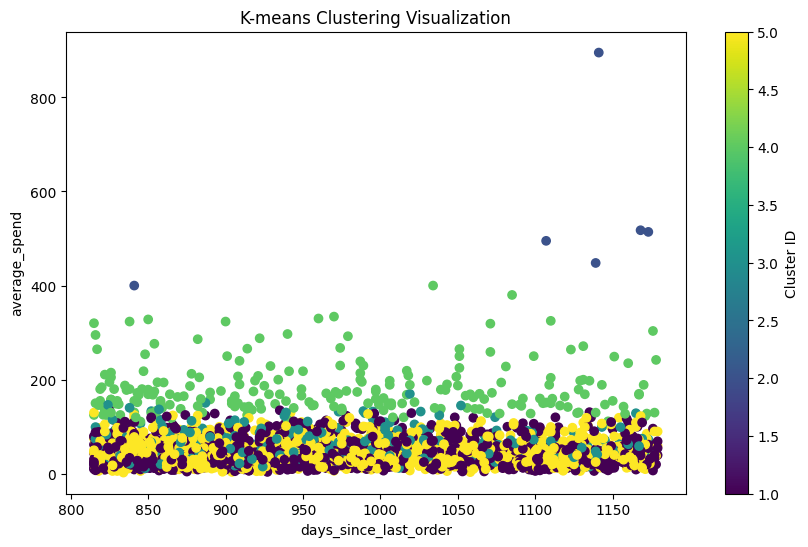

In [ ]:
# prompt: visualizar el clustering creado

import matplotlib.pyplot as plt

# Assuming 'predictions_df' contains the cluster labels and features for plotting
# Replace 'feature1' and 'feature2' with the actual column names from your DataFrame

plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('days_since_last_order')
plt.ylabel('average_spend')
plt.title('K-means Clustering Visualization')
plt.colorbar(label="Cluster ID")
plt.show()

### **Resumen por cada cluster**

In [ ]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,45.40,1.28,966.27
1,cluster 2,618.41,1.22,958.85
2,cluster 3,59.01,3.69,955.16
3,cluster 4,184.46,1.24,981.14
4,cluster 5,46.66,1.29,991.79


In [ ]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $45.4, count of orders per person 1.28, days since last order 966.27
cluster 2, average spend $618.41, count of orders per person 1.22, days since last order 958.85
cluster 3, average spend $59.01, count of orders per person 3.69, days since last order 955.16
cluster 4, average spend $184.46, count of orders per person 1.24, days since last order 981.14
cluster 5, average spend $46.66, count of orders per person 1.29, days since last order 991.79


### **Generar campaña de marketing con Gemini**

In [ ]:
model = GenerativeModel("gemini-2.0-flash")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

Okay, here's a breakdown of each cluster, a creative title for the persona, a detailed persona description, and a strategic next marketing action, designed to re-engage and/or nurture each group:

**Cluster 1: The "Lost Souls"**

*   **Title:** The "Budget Explorer"
*   **Persona:**
    *   **Name:** Emily Carter
    *   **Demographics:** 28, Female, Entry-level professional, lives in a city apartment.
    *   **Psychographics:** Value-conscious, enjoys discovering new brands but hesitant to commit to expensive purchases. Interested in sustainable and ethically sourced products. Easily distracted by other brands and offers.
    *   **Behavior:** Made a small purchase a long time ago, likely driven by a specific need or promotion. Hasn't returned due to lack of compelling reasons or forgetting about the brand.
    *   **Pain Points:** Overwhelmed by choices, hesitant to spend money on unknown brands, needs reassurance about quality and value.
*   **Next Marketing Step:**
    1.  **Re-En